# Setting Up

In [2]:
from fastai.vision.all import *
from fastai.metrics import *
import pandas as pd
import pathlib as Path

# Name extraction

In [3]:
csv_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
skin_df = pd.read_csv(csv_path)
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [4]:
name_conv_dict = {
    "akiec" : "Actinic Keratoses", # Skin cancer 
    "bcc" : "Basal Cell Carcinoma" , # White skin cancer
    "bkl" : "Seborrheic Keratoses", # (NC) Skin tumour
    "df" : "Dermatofibroma lesions", # (NC) Rounded bumps 
    "mel" : "Melanoma", # Black skin cancer
    "nv" : "Melanocytic nevi", # (NC) Mole
    "vasc" : "Vascular lesions", # Skin condition
}

In [5]:
skin_df['dx'] = skin_df['dx'].replace(name_conv_dict)

Converting the short forms

In [6]:
def get_dx_value(image_path):
    # Get the 'dx' value corresponding to the given file name
    dx_value = skin_df.loc[skin_df['image_id'] == image_path.stem, 'dx'].values[0]
    return dx_value

# Creating a datablock

In [7]:
dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = get_dx_value,
    item_tfms=[Resize(448)],
    batch_tfms=Resize(448, method='Squish'))

img_path = "/kaggle/input/skin-cancer-mnist-ham10000"
dls = dblock.dataloaders(img_path, bs=64)
                        

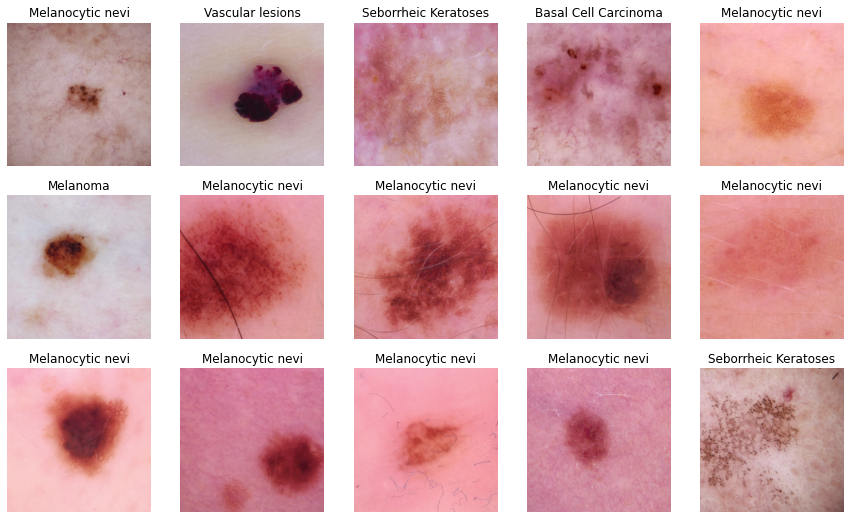

In [8]:
dls.show_batch(max_n=15)

# Training

In [9]:
torch.cuda.empty_cache()

In [10]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.048849,0.693349,0.774338,06:28


epoch,train_loss,valid_loss,accuracy,time
0,0.553260,0.414800,0.857214,05:33
1,0.365398,0.386905,0.866450,05:32
2,0.182091,0.178205,0.946830,05:30
3,0.065449,0.133133,0.969546,05:34
4,0.034252,0.130801,0.971792,05:34


# Loss interpretation

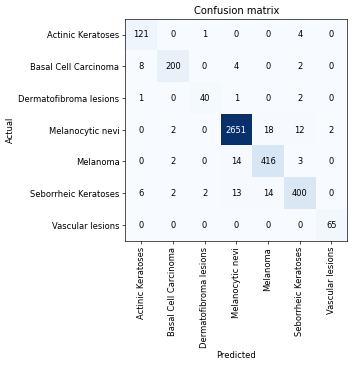

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

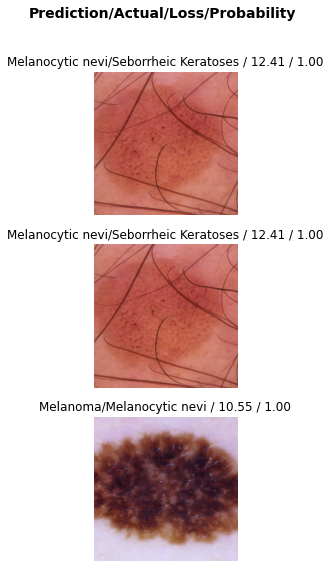

In [12]:
interp.plot_top_losses(3, nrows=3)

# Ensemble

In [22]:
torch.cuda.empty_cache()

In [27]:
from pathlib import Path

In [28]:
new_path = Path('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1')

In [29]:
# load different models
learn1 = load_learner('/kaggle/input/pkl-ham10000/bs8_swin_s3_tiny_224.pkl', cpu=False)
learn1.dls.to(device='cuda')
learn1.model.to(device='cuda')

learn2 = load_learner('/kaggle/input/pkl-ham10000/bs8_resnet50.pkl', cpu=False)
learn2.dls.to(device='cuda')
learn2.model.to(device='cuda')

learn3 = load_learner('/kaggle/input/pkl-ham10000/bs8_levit384.pkl', cpu=False)
learn3.dls.to(device='cuda')
learn3.model.to(device='cuda')

learn4 = load_learner('/kaggle/input/pkl-ham10000/bs8_efficientnetv2_rw_t.pkl', cpu=False)
learn4.dls.to(device='cuda')
learn4.model.to(device='cuda')

test_files = [fn for fn in sorted((new_path).glob('**/*')) if fn.is_file()]

# batch prediction
test_dl = learn1.dls.test_dl(test_files)
preds1, _, decoded1 = learn1.get_preds(dl=test_dl, with_decoded=True)

test_dl2 = learn2.dls.test_dl(test_files)
preds2, _, decoded2 = learn2.get_preds(dl=test_dl2, with_decoded=True)

test_dl3 = learn3.dls.test_dl(test_files)
preds3, _, decoded3 = learn3.get_preds(dl=test_dl3, with_decoded=True)

test_dl4 = learn4.dls.test_dl(test_files)
preds4, _, decoded4 = learn4.get_preds(dl=test_dl4, with_decoded=True)


In [30]:
# get the labels from the decoded values
decoded_labels1 = [learn1.dls.vocab[idx] for idx in decoded1.numpy()]
decoded_labels2 = [learn2.dls.vocab[idx] for idx in decoded2.numpy()]
decoded_labels3 = [learn3.dls.vocab[idx] for idx in decoded3.numpy()]
decoded_labels4 = [learn4.dls.vocab[idx] for idx in decoded4.numpy()]

In [31]:
# convert to dataframe
decoded_labels1_df = pd.DataFrame({'decoded_labels1': decoded_labels1})
decoded_labels2_df = pd.DataFrame({'decoded_labels1': decoded_labels2})
decoded_labels3_df = pd.DataFrame({'decoded_labels1': decoded_labels3})
decoded_labels4_df = pd.DataFrame({'decoded_labels1': decoded_labels4})

In [32]:
# extract file name
actual_labels = [fn.stem for fn in test_files]
actual_labels_df = pd.DataFrame({'image_id': actual_labels})

In [33]:
# merge dataframe
merged_df1 = decoded_labels1_df.join(actual_labels_df)
merged_df2 = decoded_labels2_df.join(actual_labels_df)
merged_df3 = decoded_labels3_df.join(actual_labels_df)
merged_df4 = decoded_labels4_df.join(actual_labels_df)

sorted_merged_df1 = merged_df1.sort_values(by='image_id')
sorted_merged_df2 = merged_df2.sort_values(by='image_id')
sorted_merged_df3 = merged_df3.sort_values(by='image_id')
sorted_merged_df4 = merged_df4.sort_values(by='image_id')

In [34]:
sorted_merged_df1[:5]

,decoded_labels1,image_id
0,Melanocytic nevi,ISIC_0024306
1,Melanocytic nevi,ISIC_0024307
2,Melanocytic nevi,ISIC_0024308
3,Melanocytic nevi,ISIC_0024309
4,Melanoma,ISIC_0024310


In [35]:
# actual labels dataframe
sorted_skin_df = skin_df.sort_values(by='image_id')
sorted_skin_df = sorted_skin_df[['image_id', 'dx']]
sorted_skin_df

,image_id,dx
4349,ISIC_0024306,Melanocytic nevi
4263,ISIC_0024307,Melanocytic nevi
4217,ISIC_0024308,Melanocytic nevi
3587,ISIC_0024309,Melanocytic nevi
1451,ISIC_0024310,Melanoma
...,...,...
1721,ISIC_0034316,Melanoma
1888,ISIC_0034317,Melanoma
121,ISIC_0034318,Seborrheic Keratoses
7440,ISIC_0034319,Melanocytic nevi


In [36]:
merged_df1 = sorted_merged_df1.merge(sorted_skin_df, on='image_id')
merged_df1

,decoded_labels1,image_id,dx
0,Melanocytic nevi,ISIC_0024306,Melanocytic nevi
1,Melanocytic nevi,ISIC_0024307,Melanocytic nevi
2,Melanocytic nevi,ISIC_0024308,Melanocytic nevi
3,Melanocytic nevi,ISIC_0024309,Melanocytic nevi
4,Melanoma,ISIC_0024310,Melanoma
...,...,...,...
4995,Seborrheic Keratoses,ISIC_0029301,Seborrheic Keratoses
4996,Seborrheic Keratoses,ISIC_0029302,Seborrheic Keratoses
4997,Melanocytic nevi,ISIC_0029303,Melanocytic nevi
4998,Melanocytic nevi,ISIC_0029304,Melanocytic nevi


In [37]:
# actual and predicted labels
merged_df2 = sorted_merged_df2.merge(sorted_skin_df, on='image_id')
merged_df3 = sorted_merged_df3.merge(sorted_skin_df, on='image_id')
merged_df4 = sorted_merged_df4.merge(sorted_skin_df, on='image_id')

In [38]:
# comparison between actual and predicted labels
merged_df1['truth'] = np.where(merged_df1['dx'] == merged_df1['decoded_labels1'], 1, 0)
merged_df2['truth'] = np.where(merged_df2['dx'] == merged_df2['decoded_labels1'], 1, 0)
merged_df3['truth'] = np.where(merged_df3['dx'] == merged_df3['decoded_labels1'], 1, 0)
merged_df4['truth'] = np.where(merged_df4['dx'] == merged_df4['decoded_labels1'], 1, 0)

In [39]:
accuracy1 = merged_df1['truth'].mean()
accuracy2 = merged_df2['truth'].mean()
accuracy3 = merged_df3['truth'].mean()
accuracy4 = merged_df4['truth'].mean()


In [40]:
# acc calculation
accuracy = (accuracy1 + accuracy1 + accuracy1 + accuracy1)/ 4
accuracy

0.981

In [41]:
# f1 score calculation
# split dataframe acc to skin disease
grouped1 = merged_df1.groupby('dx')
grouped2 = merged_df2.groupby('dx')
grouped3 = merged_df3.groupby('dx')
grouped4 = merged_df4.groupby('dx')

df_list1 = [group for _, group in grouped1]
df_list2 = [group for _, group in grouped2]
df_list3 = [group for _, group in grouped3]
df_list4 = [group for _, group in grouped4]

In [42]:
# group malignant and benign skin disease
combined_df1_m = pd.concat([df_list1[0], df_list1[1], df_list1[4], df_list1[6]], axis=0)
combined_df1_b = pd.concat([df_list1[2], df_list1[3], df_list1[5]], axis=0)
  
#true positive and false negative    
tp_df1 = ones_df1_m = combined_df1_m['truth'].value_counts()[1]
fn_df1 = zeros_df1_m = combined_df1_m['truth'].value_counts()[0]

#false positive and true negative
fp_df1 = ones_df1_b = combined_df1_b['truth'].value_counts()[1]
tn_df1 = zeros_df1_b = combined_df1_b['truth'].value_counts()[0]

#f1 score for model 1
f1_df1=tp_df1/(tp_df1+fn_df1)
f1_df1                            

0.9441517386722866

In [43]:
combined_df2_m = pd.concat([df_list2[0], df_list2[1], df_list2[4], df_list2[6]], axis=0)
combined_df2_b = pd.concat([df_list2[2], df_list2[3], df_list2[5]], axis=0)
                            
tp_df2 = ones_df2_m = combined_df2_m['truth'].value_counts()[1]
fn_df2 = zeros_df2_m = combined_df2_m['truth'].value_counts()[0]
                            
fp_df2 = ones_df2_b = combined_df2_b['truth'].value_counts()[1]
tn_df2 = zeros_df2_b = combined_df2_b['truth'].value_counts()[0]

#f1 score for model 2
f1_df2=tp_df2/(tp_df2+fn_df2)
f1_df2                            

0.9715489989462592

In [44]:
combined_df3_m = pd.concat([df_list3[0], df_list3[1], df_list3[4], df_list3[6]], axis=0)
combined_df3_b = pd.concat([df_list3[2], df_list3[3], df_list3[5]], axis=0)
                            
tp_df3 = ones_df3_m = combined_df3_m['truth'].value_counts()[1]
fn_df3 = zeros_df3_m = combined_df3_m['truth'].value_counts()[0]
                            
fp_df3 = ones_df3_b = combined_df3_b['truth'].value_counts()[1]
tn_df3 = zeros_df3_b = combined_df3_b['truth'].value_counts()[0]

#f1 score for model 3
f1_df3=tp_df3/(tp_df3+fn_df3)
f1_df3                            

0.7218124341412012

In [45]:
combined_df4_m = pd.concat([df_list4[0], df_list4[1], df_list4[4], df_list4[6]], axis=0)
combined_df4_b = pd.concat([df_list4[2], df_list4[3], df_list4[5]], axis=0)
                            
tp_df4 = ones_df4_m = combined_df4_m['truth'].value_counts()[1]
fn_df4 = zeros_df4_m = combined_df4_m['truth'].value_counts()[0]
                            
fp_df4 = ones_df4_b = combined_df4_b['truth'].value_counts()[1]
tn_df4 = zeros_df4_b = combined_df4_b['truth'].value_counts()[0]

#f1 score for model 4
f1_df4=tp_df4/(tp_df4+fn_df4)
f1_df4                            

0.7091675447839831

In [46]:
#f1 score
f1 = (f1_df1+f1_df2+f1_df3+f1_df4)/4
f1

0.8366701791359326